Understanding
How Kernel Choice Affects SVM Performance
Using the Iris Dataset

This notebook accompanies the tutorial "Understanding How Kernel Choice Affects SVM Performance (Using the Iris Dataset)".

It demonstrates how different Support Vector Machine (SVM) kernels:

change the geometry of the decision boundary
affect classification performance
interact with key hyperparameters (C, gamma, degree)
The code in this notebook is designed:

Dataset: Iris (from Iris.csv)
Train/test split: 75% train, 25% test, stratified by class
Pipeline: StandardScaler → SVC
Kernels compared: linear, rbf, poly, sigmoid
Hyperparameters explored with GridSearchCV and 4-fold stratified cross-validation

1. Imports and configuration

2. Load and inspect the Iris dataset
We use the Iris.csv file provided with this repository.
The dataset contains:

150 samples
4 features: sepal length, sepal width, petal length, petal width
3 classes (species)

In [7]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# If you uploaded Iris.csv, the notebook will use it; otherwise fallback to sklearn's iris
csv_path = '/mnt/data/Iris.csv'  # change if needed
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # try to detect species column
    if 'species' in df.columns:
        species_col = 'species'
    elif 'Species' in df.columns:
        species_col = 'Species'
    else:
        species_col = df.columns[-1]
    X = df.drop(columns=[species_col]).select_dtypes(include=[np.number]).values
    y = df[species_col].values
else:
    iris = datasets.load_iris(as_frame=True)
    df = iris.frame.copy()
    df.columns = list(iris.feature_names) + ['species']
    X = iris.data.values
    y = np.array([iris.target_names[i] for i in iris.target])

print("Dataset shape:", X.shape)
print("Unique classes:", np.unique(y))


Dataset shape: (150, 4)
Unique classes: ['setosa' 'versicolor' 'virginica']


3. Train–test split
We drop the Id column (not a useful feature)
use the 4 flower measurements as features
use Species as the target
perform a stratified 75/25 split to preserve class balance

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
param_grid = {
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale'],
    'svc__degree': [2, 3]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV mean accuracy:", grid.best_score_)
best_model = grid.best_estimator_


Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params: {'svc__C': 0.1, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV mean accuracy: 0.9732142857142858


In [9]:
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Save summary
out_dir = '/mnt/data/iris_svm_tutorial_outputs'
os.makedirs(out_dir, exist_ok=True)
summary = {
    "best_params": grid.best_params_,
    "best_cv_score": float(grid.best_score_),
    "test_accuracy": float(accuracy_score(y_test, y_pred))
}
with open(os.path.join(out_dir, 'results_summary.txt'), 'w') as f:
    f.write(str(summary) + '\n\n')
    f.write(classification_report(y_test, y_pred))


Test accuracy: 0.9210526315789473

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.86      0.92      0.89        13
   virginica       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38


Confusion matrix:
 [[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]


#4 Cross-validated accuracy vs C (per kernel)
Here we visualise how C affects performance for each kernel.

Small C → wider margin, more regularisation
Large C → narrower margin, less regularisation, potential overfitting

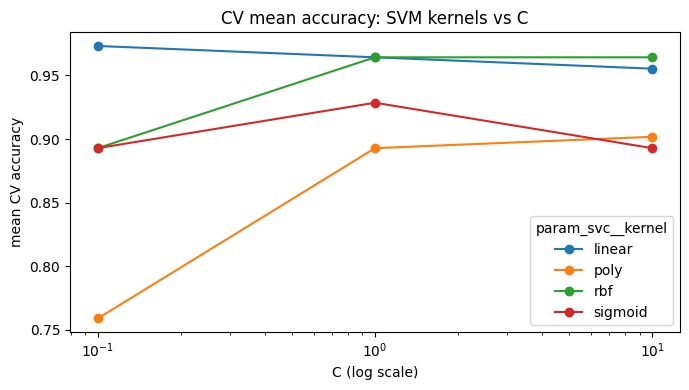

In [10]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
pivot = results.pivot_table(values='mean_test_score',
                            index='param_svc__C',
                            columns='param_svc__kernel')
ax = pivot.plot(marker='o', figsize=(7,4))
ax.set_xscale('log')
ax.set_xlabel('C (log scale)')
ax.set_ylabel('mean CV accuracy')
ax.set_title('CV mean accuracy: SVM kernels vs C')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'cv_scores_by_kernel_C.png'))
plt.show()


#5 Decision boundary visualisations
To connect geometry with performance, we plot the decision boundaries for:

Features (0, 1): sepal length vs sepal width
Features (2, 3): petal length vs petal width
and for each kernel:

linear
poly (degree 3 by default here for illustration)
rbf
sigmoid
These are 2D projections of the problem, so the decision boundaries will not perfectly match the full 4D training, but they are very useful for building intuition.

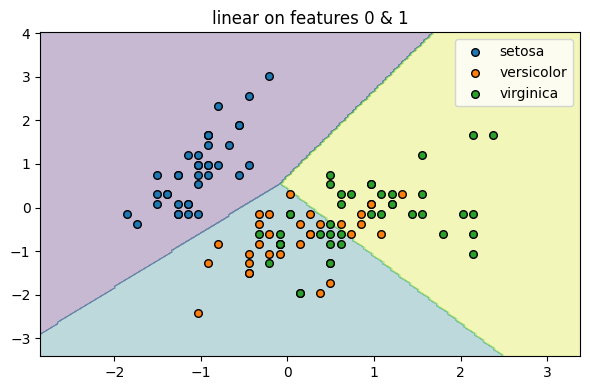

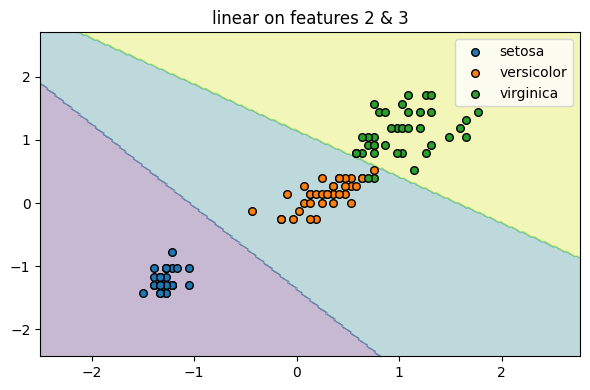

In [11]:
from sklearn.preprocessing import StandardScaler
def plot_decision_boundary(svc, X, y, feature_idx=(0,1), savepath=None, title=''):
    X_sub = X[:, feature_idx]
    scaler = StandardScaler().fit(X_sub)
    Xs = scaler.transform(X_sub)
    svc_local = SVC(kernel=svc.kernel, C=svc.C, degree=getattr(svc, 'degree', 3), gamma=svc.gamma)
    svc_local.fit(Xs, y)
    x_min, x_max = Xs[:,0].min()-1, Xs[:,0].max()+1
    y_min, y_max = Xs[:,1].min()-1, Xs[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
    Z = svc_local.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    classes = np.unique(y)
    class_to_num = {c:i for i,c in enumerate(classes)}
    Z_num = np.vectorize(class_to_num.get)(Z)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, Z_num, alpha=0.3)
    for cls in classes:
        mask = (y == cls)
        plt.scatter(Xs[mask,0], Xs[mask,1], label=str(cls), edgecolor='k', s=30)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

svc_component = best_model.named_steps['svc']
plot_decision_boundary(svc_component, X_train, y_train, (0,1), os.path.join(out_dir,'decision_best_0_1.png'),
                       title=f"{svc_component.kernel} on features 0 & 1")
plot_decision_boundary(svc_component, X_train, y_train, (2,3), os.path.join(out_dir,'decision_best_2_3.png'),
                       title=f"{svc_component.kernel} on features 2 & 3")


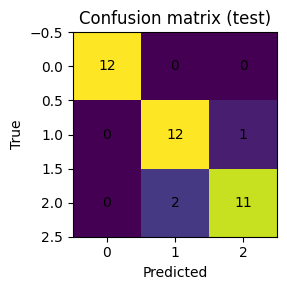

In [12]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
for (i,j),val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix (test)')
plt.tight_layout()
plt.savefig(os.path.join(out_dir,'confusion_matrix_test.png'))
plt.show()


Summary


Implemented an SVM classifier with four kernels (linear, poly, rbf, sigmoid)
Used a StandardScaler + SVC Pipeline
Performed 4-fold stratified cross-validation with a grid over C, gamma and degree
Visualised CV accuracy vs C per kernel
Evaluated the best model on a held-out test set

https://github.com/Sethu1249/the-iris